# Adult Census Income Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind

# For inline plotting
%matplotlib inline

from ucimlrepo import fetch_ucirepo

# Fetch the Adult dataset (UCI repository id=2)
adult = fetch_ucirepo(id=2)

# Extract features and target
X = adult.data.features
y = adult.data.targets

# Display metadata and variable information
print('Metadata:')
print(adult.metadata)

print('\nVariable Information:')
print(adult.variables)

Metadata:
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted usi

## Data Overview

Let's inspect the dataset by viewing the first few rows, checking data types, and looking at basic statistics.

In [4]:
# Display the first few rows of features
display(X.head())

# Basic info about the dataset
X.info()

# Summary statistics
print(X.describe())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.0

## Missing Values and Data Cleaning

Checking for missing values in the dataset and also tidying the data

In [6]:
# Check for missing values in the features
print('Missing values per column in X:')
display(X.isnull().sum())
print()
print(y.value_counts()) # Shows that there are trailing . for the incomes
print()

# Converting y to Series
y = y.iloc[:, 0]
# removing the "."
y = y.str.replace(r'\.', '', regex=True)
print(y.value_counts())

Missing values per column in X:


age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64


income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

income
<=50K    37155
>50K     11687
Name: count, dtype: int64


## Visualizing the Income Distribution

Examing the distribution of income, which indicates whether a person earns more than $50K per year.

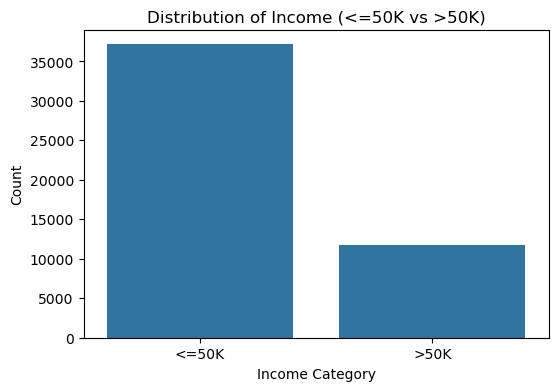

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of Income (<=50K vs >50K)')
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.show()

## Analysis of Numeric Features

Inspecting the numeric features.

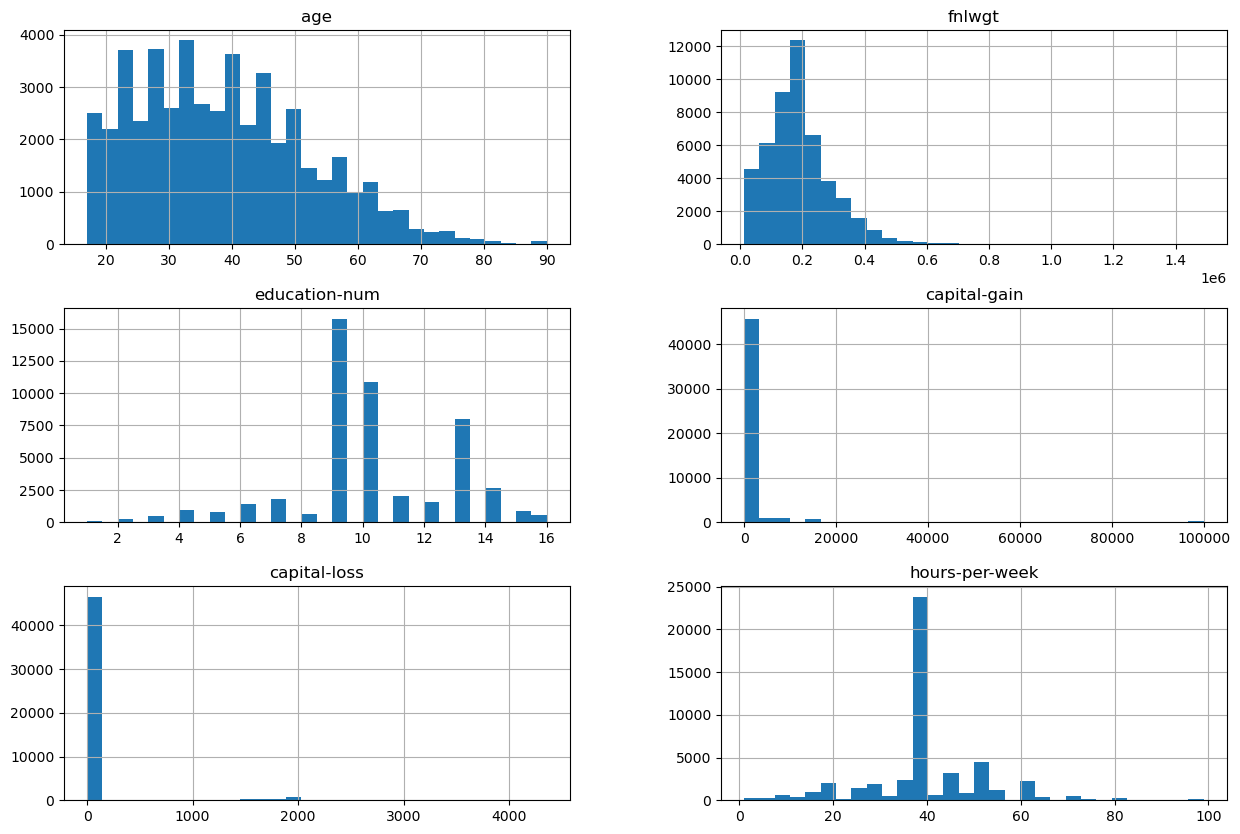

In [10]:
# Select only numeric columns from the feature set
numeric_cols = X.select_dtypes(include=[np.number])

numeric_cols.hist(bins=30, figsize=(15, 10));
plt.show()

## Analysis of Categorical Features

Inspecting the categorical features.

Categorical Columns:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


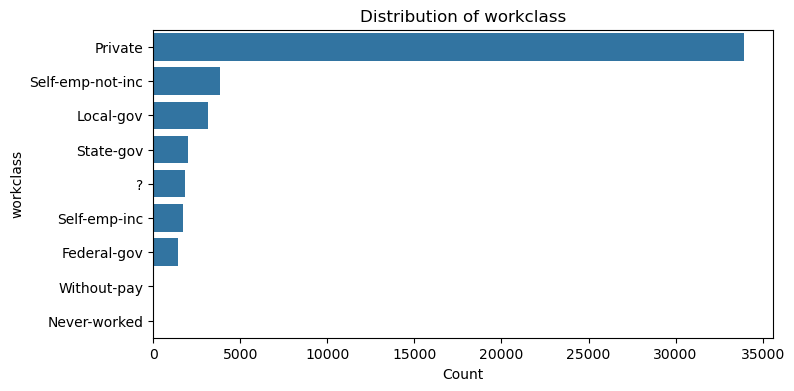

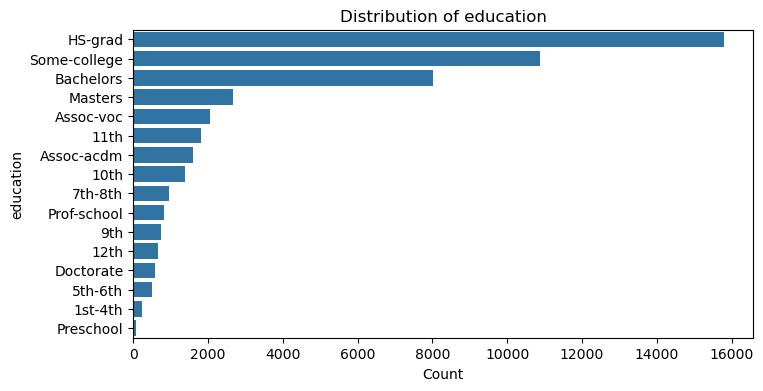

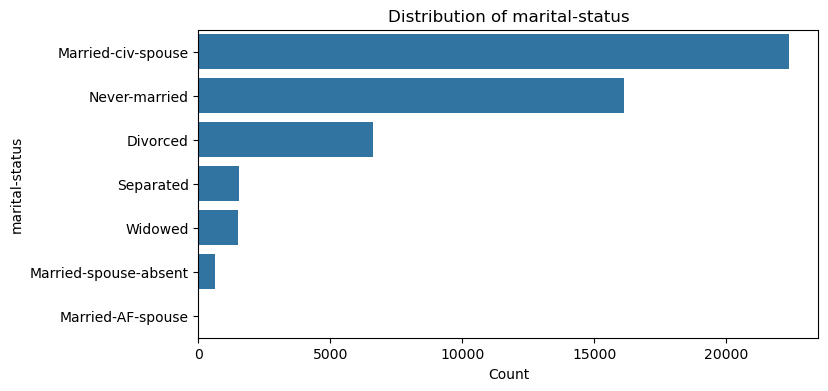

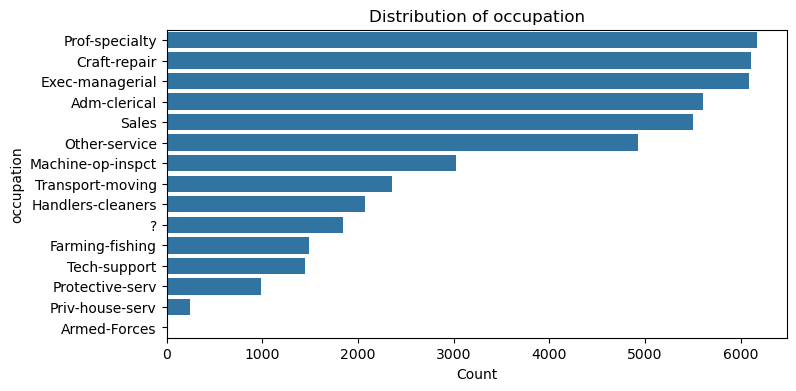

In [12]:
categorical_cols = X.select_dtypes(include=['object']).columns

print('Categorical Columns:')
print(categorical_cols.tolist())

# Plot count plots for a subset of categorical columns
for col in categorical_cols[:4]:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=X[col], order=X[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

## Hypothesis

**Hypothesis:** _Individuals who have a higher Education Level will tend to have a higher income_


In [14]:
education_income_table = pd.crosstab(X['education'], y)
print("Contingency Table (Education vs Income):")
print(education_income_table)

# Perform Chi-Square test of independence
chi2, p, dof, expected = chi2_contingency(education_income_table)
print("p-value:", p)

if p < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant association between education and income.")
else:
    print("Conclusion: Fail to reject the null hypothesis. No significant association between education and income.")

Contingency Table (Education vs Income):
income        <=50K  >50K
education                
10th           1302    87
11th           1720    92
12th            609    48
1st-4th         239     8
5th-6th         482    27
7th-8th         893    62
9th             715    41
Assoc-acdm     1188   413
Assoc-voc      1539   522
Bachelors      4712  3313
Doctorate       163   431
HS-grad       13281  2503
Masters        1198  1459
Preschool        82     1
Prof-school     217   617
Some-college   8815  2063
p-value: 0.0
Conclusion: Reject the null hypothesis. There is a significant association between education and income.


## Conclusion

There is significant positive correlation between the education level and whether someone makes above $50k. The p-value provides strong evidence against the null hypothesis